In [1]:
%cd ../../

/home/matej/prace/ferda/ferda_github


In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from imageio import imread
import numpy as np
import os
from os.path import join
from scripts.CNN.train_interactions import COLUMNS, match_pred_to_gt, model
import pandas as pd
from scripts.CNN.interactions_results import toarray, tostruct
import warnings
pd.set_option('precision', 2)
import seaborn as sns
sns.set()

In [56]:
DATA_DIRS = [
    '/home/matej/prace/ferda/data/interactions/1712_36k_random',
    '/home/matej/prace/ferda/data/interactions/1712_36k_random',
]
    
EXPERIMENT_DIRS = [
    '/home/matej/prace/ferda/experiments/171222_0126_batch_36k_random/0.928571428571',
    '/home/matej/prace/ferda/experiments/180118_2231_dim_mask/0.857142857143',
]

EXPERIMENT_NAMES = [
    '171222_0126_batch_36k_random',
    '180118_2231_dim_mask'   
]

In [67]:
y_test = []
pred = []
for i in range(len(EXPERIMENT_DIRS)):
    y_test.append(pd.read_csv(join(DATA_DIRS[i], 'test.csv')))
    with h5py.File(join(EXPERIMENT_DIRS[i], 'predictions.h5'), 'r') as hf:
        pred.append(pd.DataFrame(tostruct(hf['data'][:])))    
    assert pred[-1].shape[1] % len(COLUMNS) == 0
    
n_objects = pred[0].shape[1] / len(COLUMNS)

In [68]:
# 180118_2231_dim_mask has been learnt on y_test with reversed angles
for i in [1]: 
    for j in range(n_objects):
        y_test[i]['%d_angle_deg' % j] *= -1

# Predictions

In [59]:
# pred_df.describe()

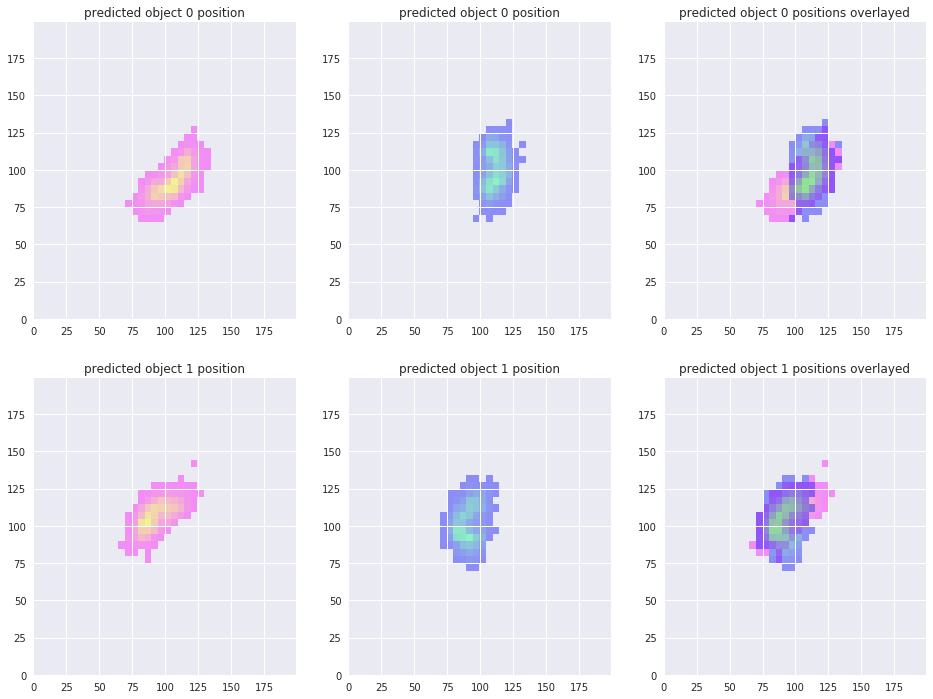

In [60]:
# colormaps = ['Blues', 'Reds']

colormaps = ['spring', 'winter']
plt.figure(figsize=(16, 12))
for i in range(n_objects):
    for j in range(len(EXPERIMENT_DIRS)):
        plt.subplot(n_objects, len(EXPERIMENT_DIRS) + 1, i * (len(EXPERIMENT_DIRS) + 1) + j + 1)
        plt.title('predicted object %d position' % i)
        _ = plt.hist2d(pred[j]['%d_x' % i], pred[j]['%d_y' % i], 
                       bins=40, cmin=1, alpha=0.4, range=((0, 199), (0, 199)), cmap=colormaps[j])        
        
        
    plt.subplot(n_objects, len(EXPERIMENT_DIRS) + 1, i * (len(EXPERIMENT_DIRS) + 1) + len(EXPERIMENT_DIRS) + 1)
    plt.title('predicted object %d positions overlayed' % i)
    for j in range(len(EXPERIMENT_DIRS)):
        _, _, _, img = plt.hist2d(pred[j]['%d_x' % i], pred[j]['%d_y' % i], 
                       bins=40, cmin=1, alpha=0.4, range=((0, 199), (0, 199)), cmap=colormaps[j])
#         clb = plt.colorbar()
#         clb.ax.set_title(EXPERIMENT_NAMES[j], x=0, y=0.5, rotation='vertical', horizontalalignment='right', verticalalignment='center',)

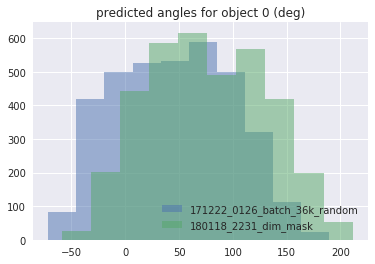

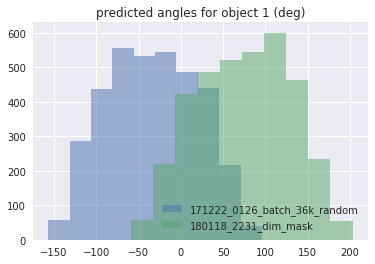

In [69]:
for i in range(n_objects):
    plt.figure()
    for j in range(len(EXPERIMENT_DIRS)):
        plt.title('predicted angles for object %d (deg)' % i)
        (pred[j]['%d_angle_deg' % i]).hist(
            alpha=0.5, label=EXPERIMENT_NAMES[j])
    plt.legend(loc='lower right')
# NOTE: 180118_2231_dim_mask has been learnt on y_test with reversed angles     

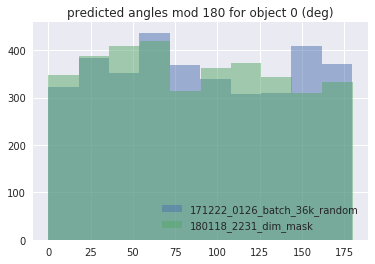

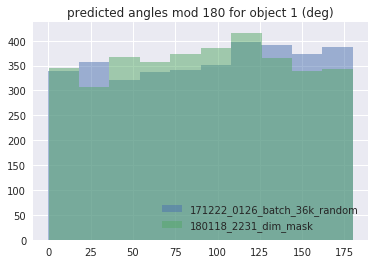

In [70]:
for i in range(n_objects):
    plt.figure()
    for j in range(len(EXPERIMENT_DIRS)):
        plt.title('predicted angles mod 180 for object %d (deg)' % i)
        (pred[j]['%d_angle_deg' % i] % 180).hist(alpha=0.5, label=EXPERIMENT_NAMES[j])
    plt.legend(loc='lower right')

# Prediction Errors

In [71]:
PRED_COLUMNS = ['x', 'y', 'major', 'minor', 'angle_deg']
columns = []
for i in range(n_objects):
    columns.extend(['%d_%s' % (i, c) for c in PRED_COLUMNS])
    
def get_errors(pred, gt):
    xy, angle, indices = match_pred_to_gt(pred[columns].values,
                                          gt[columns].values, np)
    if n_objects == 1:
        xy_errors = xy
        angle_errors = angle
    elif n_objects == 2:
        xy_errors = (xy[indices[:, 0], indices[:, 1]])
        angle_errors = (angle[indices[:, 0], indices[:, 1]])
    else:
        assert False, 'not implemented'
    return xy_errors, angle_errors

# swap = indices[:, 0] == 1
# pred_swapped = pred.copy()
# pred_swapped[swap, :5], pred_swapped[swap, 5:] = pred_swapped[swap, 5:], pred_swapped[swap, :5]
  
xy_errors, angle_errors = zip(*[get_errors(pred_, gt) for pred_, gt in zip(pred, y_test)])

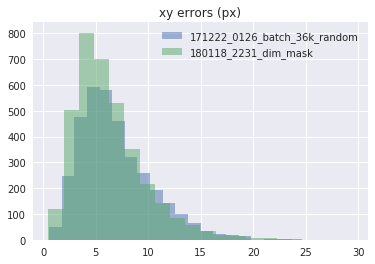

In [72]:
for i in range(len(xy_errors)):
    _  = plt.hist(xy_errors[i], 20, alpha=0.5, label=EXPERIMENT_NAMES[i])
plt.legend()
plt.title('xy errors (px)')

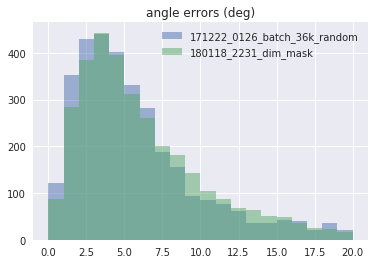

In [73]:
for i in range(len(angle_errors)):
    _  = plt.hist(angle_errors[i], 20, range=(0, 20), alpha=0.5, label=EXPERIMENT_NAMES[i])
plt.legend()
plt.title('angle errors (deg)')